# CamemBERT for text classification task

CamemBERT is a state-of-the-art language model for French based on the RoBERTa model.

It is now available on Hugging Face in 6 different versions with varying number of parameters, amount of pretraining data and pretraining data source domains.
For more information here's the huggingface website: https://huggingface.co/camembert-base

In this notebook I would like to finetune a camembert model for classifying french tweets based on the french-twitter-sentiment-analysis dataset: https://www.kaggle.com/hbaflast/french-twitter-sentiment-analysis

In [1]:
cd ../..

/Volumes/Geek/Work/Patat


In [2]:
_rs = 42 # Random State

# Imports
---

In [3]:
# Importing standard libraries for every machine/deep learning pipeline
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm import tqdm, trange



# Importing specific libraries for data prerpcessing, model archtecture choice, training and evaluation
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from transformers import AdamW
# import torch.optim as optim
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import seaborn as sns

# Data
___

## Chargement

In [4]:
import patat.util.file

filename = 'data/prod/230517-OIDS-Label.pickle'

df_label = patat.util.file.pickle_load(filename)

## Labels ou textes nuls

In [5]:
# Textes nuls
df_label['text'].isna().sum()

0

In [6]:
# Labels nuls
df_label['infox'].isna().sum()

4

In [7]:
df_label = df_label[df_label['infox'].notna()]
df_label.reset_index(inplace=True)

## Données dupliquées

In [8]:
df_label.duplicated(subset='text').sum()

0

In [9]:
df_label.duplicated(subset='url').sum()

0

## Preprocessing textes

In [10]:
import patat.util.text

df_label['pp_text']=df_label['text'].apply(patat.util.text.preprocess)

## Equilibrage Dataset

<Axes: xlabel='infox', ylabel='count'>

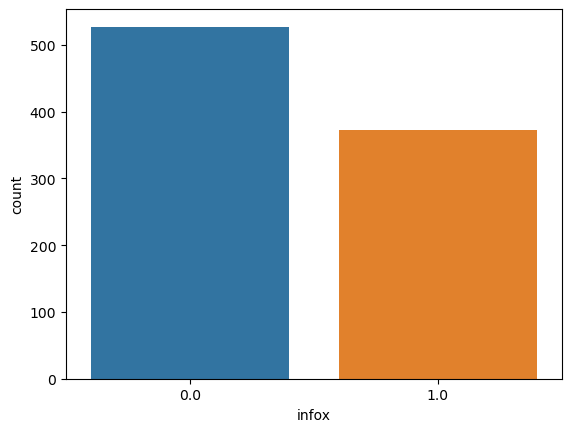

In [11]:
label_count = df_label['infox'].value_counts()
sns.barplot(x=label_count.index, y=label_count)

In [12]:
df_0 = df_label[df_label['infox'] == 0]
df_1 = df_label[df_label['infox'] == 1]

min_sample = min(len(df_0),len(df_1))

df_0=df_0.sample(min_sample,random_state=_rs)
df_1=df_1.sample(min_sample,random_state=_rs)
df_ml = pd.concat([df_0,df_1])

df_ml

,index,url,site,title,article,tags,paragraphs,date_iso,abstract,Auteur,...,denigrement,degre_infox,observateur,source,p_count,text,c_count,p_size,url_h,pp_text
609,610,https://www.francesoir.fr/politique-france/gue...,www.francesoir.fr,Guerre en Ukraine: Emmanuel Macron prévient le...,À l’occasion de la cérémonie pour le 78e anniv...,"[Accueil, Politique]",[À l’occasion de la cérémonie pour le 78e anni...,2022-08-20T00:00:00,,,...,0.0,,CN,Recueil,11,Guerre en Ukraine: Emmanuel Macron prévient le...,2629,239.000000,857bfacdd98e36dda26f1f92cf40c992904d6386,guerre en ukraine: emmanuel macron prévient le...
705,708,https://www.profession-gendarme.com/la-vaccina...,www.profession-gendarme.com,La vaccination Covid : un marquage de « type b...,De: Dr R Date: 16 avril 2022 à 08:17:22 ﻿bonjo...,"[Actualités, Tribune]",[De: Dr R Date: 16 avril 2022 à 08:17:22 ﻿bonj...,,,NaN,...,NaN,NaN,NaN,Test1,17,La vaccination Covid : un marquage de « type b...,6252,367.764706,166d32300f4d7766a82fe39a1185f35bc347c05f,la vaccination covid : un marquage de « type b...
26,26,https://www.mondialisation.ca/colonialisme-ene...,www.mondialisation.ca,Colonialisme énergétique,Visite d’État du président de la République it...,"[Moyen-Orient et Afrique du Nord, Guerre USA O...",[Visite d’État du président de la République i...,2022-07-09T00:00:00,,Pangea Grandangolo,...,NaN,,GP,Recueil,8,Colonialisme énergétique\nVisite d’État du pré...,2794,349.250000,2a39a60fd5e2c6df0f6ec8ce9fedc2ee2eb4ab4d,colonialisme énergétique\nvisite d état du pré...
565,566,https://www.francesoir.fr/opinions-editos/de-l...,www.francesoir.fr,De l’importance d’une Assemblée vraiment natio...,"Depuis hier soir, ne serions-nous pas en train...","[Accueil, Opinions]","[Depuis hier soir, ne serions-nous pas en trai...",2022-06-20T19:46:00,,Xavier Azalbert,...,NaN,,GP,Recueil,16,De l’importance d’une Assemblée vraiment natio...,4582,286.375000,93b25370fea82c7039f7e2b00c0bd73151101af3,de l importance d une assemblée vraiment natio...
231,232,https://www.polemia.com/quelle-politique-migra...,www.polemia.com,Quelle politique migratoire pour la France ? –...,"Par André-Victor Robert, haut fonctionnaire ♦ ...","[Accueil, Géopolitique, Afrique, analyse, Andr...","[Facebook, Twitter, LinkedIn, Print Friendly, ...",,"Par André-Victor Robert, haut fonctionnaire ♦ ...",André Victor Robert,...,0.0,,FB,Recueil,31,Quelle politique migratoire pour la France ? –...,9123,294.290323,c12a81bb99810b5c13fba93abc5f9cea077a873d,quelle politique migratoire pour la france ? ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,112,https://lesdeqodeurs.fr/des-scientifiques-de-h...,lesdeqodeurs.fr,Des scientifiques de Harvard et de Johns Hopki...,Article original datant du 31/08/22 par SSRNCO...,"[ARNm, COVID, effets secondaires, étude, Harva...",[Les étudiants des universités nord-américaine...,2022-09-23T00:00:00,,,...,0.0,1,FB,Recueil,5,Des scientifiques de Harvard et de Johns Hopki...,1803,360.600000,1f56ed5fa54de7c492154ac8ee0d8d10724f1aa4,des scientifiques de harvard et de johns hopki...
157,158,https://www.voltairenet.org/article217546.html,www.voltairenet.org,L’armée russe achète des exemplaires d’armemen...,L’achat de deux canons automoteurs CAESAR fran...,[],[L’achat de deux canons automoteurs CAESAR fra...,1900-01-01T00:00:00,,,...,NaN,1,FB,Recueil,3,L’armée russe achète des exemplaires d’armemen...,718,239.333333,b3153ba0ad9e32c02a8d49c99a6748e0764b20b5,l armée russe achète des exemplaires d armemen...
522,523,https://lemediaen442.fr/onu-le-premier-ministr...,lemediaen442.fr,ONU – Le Premier ministre de Nouvelle-Zélande ...,L’argument principal de la ministre est que le...,"[Politique, Vidéos, censure, jacinda ardern, ONU]",[L’argument principal de la ministre est que l...,2022-09-29T09:56:31+02:00,"Le terrible discours de Jacinda Ardern, Premie...",,...,0.0,1,FB,Recueil,7,ONU – Le Premier ministre de Nouvelle-Zélande ...,2420,345.714286,3d47a59ef99274fd9ee96c209cc

In [13]:
df_ml['infox']=df_ml['infox'].astype(int)

# CamemBERT
---

In [15]:
# Defining constants
epochs = 5
MAX_LEN = 512
batch_size = 16
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [16]:
device

device(type='mps')

## Spliting Training and validation data

In [17]:
# Initialize CamemBERT tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base',do_lower_case=True)

In [18]:
# Creates list of texts and labels
text = df_ml['text'].to_list()
labels = df_ml['infox'].to_list()

#user tokenizer to convert sentences into tokenizer
input_ids = [
    tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN,truncation=True)
    for sent in text
]

# Pad our input tokens
input_ids = pad_sequences(input_ids,
                          maxlen=MAX_LEN,
                          dtype="long",
                          truncating="post",
                          padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)

In [19]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(
    input_ids, labels, attention_masks, random_state=42, test_size=0.2)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,
                              sampler=train_sampler,
                              batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=batch_size)


In [20]:
validation_inputs

tensor([[    5,   407,    17,  ..., 22313,   454,     6],
        [    5, 11671, 29351,  ...,   584,    17,     6],
        [    5, 10752,    92,  ...,  1347,     9,     6],
        ...,
        [    5, 20295,    10,  ..., 11730,    37,     6],
        [    5, 16199,     8,  ...,    72,    26,     6],
        [    5,    54, 15448,  ..., 14977, 16099,     6]])

# CamemBERT model

In [21]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=2)
model.to(device)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.weig

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

# Defining the parameters and metrics to optimize

In [22]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{
    'params':
    [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.01
}, {
    'params':
    [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.0
}]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=2e-5, eps=10e-8)


# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Training and evaluating our model

In [23]:
# Store our loss and accuracy for plotting if we want to visualize training evolution per epochs after the training process
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
    # Tracking variables for training
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the model
    model.train()
    for step, batch in tqdm(enumerate(train_dataloader)):
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # Get loss value
        loss = outputs[0]
        # Add it to train loss list
        train_loss_set.append(loss.item())
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

    # Tracking variables for validation
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Validation of the model
    model.eval()
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs =  model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs[:2]

        # Move logits and labels to CPU if GPU is used
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


Epoch:   0%|                                                                                                  | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.96s/it]
2it [00:03,  1.82s/it]
3it [00:04,  1.56s/it]
4it [00:06,  1.43s/it]
5it [00:07,  1.36s/it]
6it [00:08,  1.31s/it]
7it [00:09,  1.28s/it]
8it [00:11,  1.27s/it]
9it [00:12,  1.25s/it]
10it [00:13,  1.25s/it]
11it [00:14,  1.24s/it]
12it [00:15,  1.24s/it]
13it [00:17,  1.24s/it]
14it [00:18,  1.24s/it]
15it [00:19,  1.25s/it]
16it [00:20,  1.25s/it]
17it [00:22,  1.24s/it]
18it [00:23,  1.24s/it]
19it [00:24,  1.23s/it]
20it [00:25,  1.23s/it]
21it [00:27,  1.23s/it]
22it [00:28,  1.23s/it]
23it [00:29,  1.24s/it]
24it [00:30,  1.24s/it]
25it [00:32,  1.24s/it]
26it [00:33,  1.24s/it]
27it [00:34,  1.25s/it]
28it [00:35,  1.24s/it]
29it [00:37,  1.25s/it]
30it [00:38,  1.25s/it]
31it [00:39,  1.26s/it]
32it [00:40,  1.26s/it]
33it [00:42,  1.25s/it]
34it [00:43,  1.25s/it]
35it [00:44,  1.25s/it]
36it [00:45,  1.2

Train loss: 0.6581274725888905


Epoch:  20%|██████████████████                                                                        | 1/5 [00:50<03:22, 50.64s/it]

Validation Accuracy: 0.58125



0it [00:00, ?it/s]
1it [00:01,  1.96s/it]
2it [00:03,  1.53s/it]
3it [00:04,  1.40s/it]
4it [00:05,  1.33s/it]
5it [00:06,  1.29s/it]
6it [00:08,  1.27s/it]
7it [00:09,  1.26s/it]
8it [00:10,  1.25s/it]
9it [00:11,  1.24s/it]
10it [00:13,  1.24s/it]
11it [00:14,  1.23s/it]
12it [00:15,  1.23s/it]
13it [00:16,  1.23s/it]
14it [00:17,  1.23s/it]
15it [00:19,  1.23s/it]
16it [00:20,  1.23s/it]
17it [00:21,  1.23s/it]
18it [00:22,  1.24s/it]
19it [00:24,  1.24s/it]
20it [00:25,  1.23s/it]
21it [00:26,  1.23s/it]
22it [00:27,  1.23s/it]
23it [00:29,  1.23s/it]
24it [00:30,  1.23s/it]
25it [00:31,  1.23s/it]
26it [00:32,  1.23s/it]
27it [00:33,  1.23s/it]
28it [00:35,  1.23s/it]
29it [00:36,  1.23s/it]
30it [00:37,  1.23s/it]
31it [00:38,  1.23s/it]
32it [00:40,  1.23s/it]
33it [00:41,  1.23s/it]
34it [00:42,  1.23s/it]
35it [00:43,  1.24s/it]
36it [00:45,  1.24s/it]
37it [00:46,  1.24s/it]
38it [00:46,  1.23s/it]


Train loss: 0.5827304634608721


Epoch:  40%|████████████████████████████████████                                                      | 2/5 [01:40<02:30, 50.03s/it]

Validation Accuracy: 0.7541666666666667



0it [00:00, ?it/s]
1it [00:01,  1.52s/it]
2it [00:02,  1.36s/it]
3it [00:04,  1.31s/it]
4it [00:05,  1.28s/it]
5it [00:06,  1.26s/it]
6it [00:07,  1.25s/it]
7it [00:08,  1.25s/it]
8it [00:10,  1.24s/it]
9it [00:11,  1.24s/it]
10it [00:12,  1.25s/it]
11it [00:13,  1.24s/it]
12it [00:15,  1.24s/it]
13it [00:16,  1.24s/it]
14it [00:17,  1.24s/it]
15it [00:18,  1.23s/it]
16it [00:20,  1.23s/it]
17it [00:21,  1.23s/it]
18it [00:22,  1.23s/it]
19it [00:23,  1.23s/it]
20it [00:24,  1.23s/it]
21it [00:26,  1.24s/it]
22it [00:27,  1.24s/it]
23it [00:28,  1.25s/it]
24it [00:30,  1.25s/it]
25it [00:31,  1.24s/it]
26it [00:32,  1.24s/it]
27it [00:33,  1.24s/it]
28it [00:34,  1.25s/it]
29it [00:36,  1.25s/it]
30it [00:37,  1.25s/it]
31it [00:38,  1.24s/it]
32it [00:39,  1.24s/it]
33it [00:41,  1.25s/it]
34it [00:42,  1.24s/it]
35it [00:43,  1.24s/it]
36it [00:44,  1.24s/it]
37it [00:46,  1.24s/it]
38it [00:46,  1.22s/it]


Train loss: 0.4309445392144354


Epoch:  60%|██████████████████████████████████████████████████████                                    | 3/5 [02:29<01:39, 49.78s/it]

Validation Accuracy: 0.7520833333333333



0it [00:00, ?it/s]
1it [00:01,  1.52s/it]
2it [00:02,  1.36s/it]
3it [00:03,  1.30s/it]
4it [00:05,  1.27s/it]
5it [00:06,  1.26s/it]
6it [00:07,  1.25s/it]
7it [00:08,  1.25s/it]
8it [00:10,  1.25s/it]
9it [00:11,  1.24s/it]
10it [00:12,  1.24s/it]
11it [00:13,  1.23s/it]
12it [00:15,  1.23s/it]
13it [00:16,  1.23s/it]
14it [00:17,  1.24s/it]
15it [00:18,  1.24s/it]
16it [00:20,  1.24s/it]
17it [00:21,  1.24s/it]
18it [00:22,  1.24s/it]
19it [00:23,  1.24s/it]
20it [00:25,  1.23s/it]
21it [00:26,  1.23s/it]
22it [00:27,  1.23s/it]
23it [00:28,  1.23s/it]
24it [00:29,  1.24s/it]
25it [00:31,  1.24s/it]
26it [00:32,  1.23s/it]
27it [00:33,  1.23s/it]
28it [00:34,  1.23s/it]
29it [00:36,  1.23s/it]
30it [00:37,  1.23s/it]
31it [00:38,  1.23s/it]
32it [00:39,  1.23s/it]
33it [00:41,  1.23s/it]
34it [00:42,  1.23s/it]
35it [00:43,  1.23s/it]
36it [00:44,  1.23s/it]
37it [00:45,  1.23s/it]
38it [00:46,  1.22s/it]


Train loss: 0.3585239115514253


Epoch:  80%|████████████████████████████████████████████████████████████████████████                  | 4/5 [03:18<00:49, 49.58s/it]

Validation Accuracy: 0.7729166666666667



0it [00:00, ?it/s]
1it [00:01,  1.49s/it]
2it [00:02,  1.33s/it]
3it [00:03,  1.29s/it]
4it [00:05,  1.27s/it]
5it [00:06,  1.26s/it]
6it [00:07,  1.25s/it]
7it [00:08,  1.24s/it]
8it [00:10,  1.23s/it]
9it [00:11,  1.23s/it]
10it [00:12,  1.23s/it]
11it [00:13,  1.24s/it]
12it [00:15,  1.23s/it]
13it [00:16,  1.23s/it]
14it [00:17,  1.23s/it]
15it [00:18,  1.23s/it]
16it [00:19,  1.23s/it]
17it [00:21,  1.24s/it]
18it [00:22,  1.24s/it]
19it [00:23,  1.24s/it]
20it [00:24,  1.24s/it]
21it [00:26,  1.24s/it]
22it [00:27,  1.24s/it]
23it [00:28,  1.24s/it]
24it [00:29,  1.24s/it]
25it [00:31,  1.24s/it]
26it [00:32,  1.23s/it]
27it [00:33,  1.24s/it]
28it [00:34,  1.24s/it]
29it [00:36,  1.23s/it]
30it [00:37,  1.23s/it]
31it [00:38,  1.24s/it]
32it [00:39,  1.24s/it]
33it [00:41,  1.24s/it]
34it [00:42,  1.24s/it]
35it [00:43,  1.24s/it]
36it [00:44,  1.23s/it]
37it [00:45,  1.23s/it]
38it [00:46,  1.22s/it]


Train loss: 0.24483988865425713


Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:08<00:00, 49.65s/it]

Validation Accuracy: 0.7729166666666667


# Mesure de performances

In [ ]:
flat_pred